In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

In [2]:
IMAGE_PATH = 'train/images/'
MASK_PATH = 'train/mask/'

In [3]:
n_classes = 4 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.png')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  8203


In [4]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  6274
Val Size     :  1108
Test Size    :  821


Image Size (1512, 2688, 3)
Mask Size (1512, 2688)


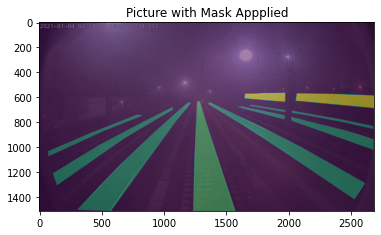

In [5]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.png')
mask = cv2.imread(MASK_PATH + df['id'][100] + '.png', cv2.IMREAD_GRAYSCALE)
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.5)
plt.title('Picture with Mask Appplied')
plt.show()

In [6]:
from torch.utils.data import DataLoader,ConcatDataset
from sklearn.model_selection import StratifiedKFold, KFold

In [7]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        mask[mask == 6] = 1
        mask[mask == 7] = 2
        mask[mask == 10] = 3

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [8]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([
    A.Resize(512, 1024, interpolation=cv2.INTER_NEAREST), 
    A.HorizontalFlip(p=0.5), 
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(p=0.5)
])

t_val = A.Compose([A.Resize(512, 1024, interpolation=cv2.INTER_NEAREST)])

# 704, 1056
#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size = 2

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)        

In [153]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=4, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [9]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [10]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        
        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas
            
            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); 
            mask = mask_tiles.to(device);

            #forward
            output = model(image)
            #mask = np.repeat(mask[None, :, :].cpu(), 4, axis=2)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); 
                    mask = mask_tiles.to(device);

                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                torch.save(model, 'model_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [60]:
kfold = KFold(n_splits=5, shuffle=False)
#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 

dataset = df['id'].values
for fold,(train_idx, test_idx) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print(train_idx[-30:])
    #print(test_idx[:30])

FOLD 0
[970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987
 988 989 990 991 992 993 994 995 996 997 998 999]
FOLD 1
[970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987
 988 989 990 991 992 993 994 995 996 997 998 999]
FOLD 2
[970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987
 988 989 990 991 992 993 994 995 996 997 998 999]
FOLD 3
[970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987
 988 989 990 991 992 993 994 995 996 997 998 999]
FOLD 4
[770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787
 788 789 790 791 792 793 794 795 796 797 798 799]


In [65]:
dataset[[0, 1, 2, 3]]

array(['img_0.00045504180876976275', 'img_0.0017079007890338227',
       'img_0.0030897967783596325', 'img_0.0036160704081735773'],
      dtype=object)

In [12]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_with_kfold(epochs, criterion, patch=False):
    torch.cuda.empty_cache()

    k_folds = 5
    
    #dataloader
    batch_size = 3
    
    #skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 
    kfold = KFold(n_splits=k_folds, shuffle=False)
    
    #X_train, X_val = train_test_split(df['id'].values, test_size=0.2, random_state=19)
    #dataset=ConcatDataset([X_train, X_val])
    dataset = df['id'].values
    
    for fold,(train_idx,test_idx) in enumerate(kfold.split(dataset)):           
        train_losses = []
        test_losses = []
        val_iou = []; val_acc = []
        train_iou = []; train_acc = []
        lrs = []
        min_loss = np.inf
        
        model = smp.FPN('efficientnet-b4', encoder_weights='imagenet', classes=4)
        
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_set = DroneDataset(IMAGE_PATH, MASK_PATH, dataset[train_idx], mean, std, t_train, patch=False)
        val_set = DroneDataset(IMAGE_PATH, MASK_PATH, dataset[test_idx], mean, std, t_val, patch=False)

        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)  
    
        optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                         steps_per_epoch=len(train_loader))
    
        model.to(device)
        fit_time = time.time()
        for e in range(epochs):
            since = time.time()
            running_loss = 0
            iou_score = 0
            accuracy = 0
            #training loop
            model.train()
            for i, data in enumerate(tqdm(train_loader)):
                #training phase
                image_tiles, mask_tiles = data
                if patch:
                    bs, n_tiles, c, h, w = image_tiles.size()

                    image_tiles = image_tiles.view(-1,c, h, w)
                    mask_tiles = mask_tiles.view(-1, h, w)
            
                image = image_tiles.to(device); 
                mask = mask_tiles.to(device);

                #forward
                output = model(image)
                #mask = np.repeat(mask[None, :, :].cpu(), 4, axis=2)
                loss = criterion(output, mask)
                #evaluation metrics
                iou_score += mIoU(output, mask)
                accuracy += pixel_accuracy(output, mask)
                #backward
                loss.backward()
                optimizer.step() #update weight          
                optimizer.zero_grad() #reset gradient
            
                #step the learning rate
                lrs.append(get_lr(optimizer))
                scheduler.step() 
            
                running_loss += loss.item()
            
            else:
                model.eval()
                test_loss = 0
                test_accuracy = 0
                val_iou_score = 0
                #validation loop
                with torch.no_grad():
                    for i, data in enumerate(tqdm(val_loader)):
                        #reshape to 9 patches from single image, delete batch size
                        image_tiles, mask_tiles = data

                        if patch:
                            bs, n_tiles, c, h, w = image_tiles.size()

                            image_tiles = image_tiles.view(-1,c, h, w)
                            mask_tiles = mask_tiles.view(-1, h, w)
                    
                        image = image_tiles.to(device)
                        mask = mask_tiles.to(device)

                        output = model(image)
                        #evaluation metrics
                        val_iou_score +=  mIoU(output, mask)
                        test_accuracy += pixel_accuracy(output, mask)
                        #loss
                        loss = criterion(output, mask)
                        test_loss += loss.item()
            
                #calculatio mean for each batch
                train_losses.append(running_loss/len(train_loader))
                test_losses.append(test_loss/len(val_loader))

                if min_loss > (test_loss/len(val_loader)):
                    print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                    min_loss = (test_loss/len(val_loader))
                    torch.save(model, 'model_mIoU-{:.3f}_fold_{}.pt'.format(val_iou_score/len(val_loader), fold))
                    
            
                #iou
                val_iou.append(val_iou_score/len(val_loader))
                train_iou.append(iou_score/len(train_loader))
                train_acc.append(accuracy/len(train_loader))
                val_acc.append(test_accuracy/ len(val_loader))
                print("Epoch:{}/{}..".format(e+1, epochs),
                      "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                      "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                      "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                      "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                      "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                      "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                      "Time: {:.2f}m".format((time.time()-since)/60))
        
        history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
        print('Total time for {} fold: {:.2f} m' .format(fold, (time.time()- fit_time)/60))
    return history

In [13]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [13]:
max_lr = 1e-3
epoch = 25
weight_decay = 1e-4


X_train, X_val = train_test_split(df['id'].values, test_size=0.2, random_state=19)

train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size = 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)

#model = torch.load('model_v2_mIoU-0.802.pt')

criterion = nn.CrossEntropyLoss()

# history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)а 
history = fit_with_kfold(epoch, criterion)

FOLD 0
--------------------------------


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.086 
Epoch:1/25.. Train Loss: 0.191.. Val Loss: 0.086.. Train mIoU:0.673.. Val mIoU: 0.787.. Train Acc:0.935.. Val Acc:0.967.. Time: 30.72m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.086 >> 0.079 
Epoch:2/25.. Train Loss: 0.097.. Val Loss: 0.079.. Train mIoU:0.784.. Val mIoU: 0.801.. Train Acc:0.964.. Val Acc:0.969.. Time: 27.94m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:3/25.. Train Loss: 0.084.. Val Loss: 0.137.. Train mIoU:0.805.. Val mIoU: 0.758.. Train Acc:0.968.. Val Acc:0.960.. Time: 27.89m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:4/25.. Train Loss: 0.085.. Val Loss: 0.082.. Train mIoU:0.807.. Val mIoU: 0.792.. Train Acc:0.969.. Val Acc:0.969.. Time: 27.91m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:5/25.. Train Loss: 0.085.. Val Loss: 0.088.. Train mIoU:0.807.. Val mIoU: 0.787.. Train Acc:0.969.. Val Acc:0.966.. Time: 27.81m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:6/25.. Train Loss: 0.082.. Val Loss: 0.088.. Train mIoU:0.811.. Val mIoU: 0.805.. Train Acc:0.969.. Val Acc:0.966.. Time: 28.32m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.079 >> 0.074 
Epoch:7/25.. Train Loss: 0.082.. Val Loss: 0.074.. Train mIoU:0.812.. Val mIoU: 0.816.. Train Acc:0.969.. Val Acc:0.973.. Time: 27.99m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.074 >> 0.069 
Epoch:8/25.. Train Loss: 0.077.. Val Loss: 0.069.. Train mIoU:0.819.. Val mIoU: 0.820.. Train Acc:0.971.. Val Acc:0.974.. Time: 27.96m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:9/25.. Train Loss: 0.072.. Val Loss: 0.082.. Train mIoU:0.826.. Val mIoU: 0.811.. Train Acc:0.973.. Val Acc:0.968.. Time: 28.05m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.069 >> 0.066 
Epoch:10/25.. Train Loss: 0.069.. Val Loss: 0.066.. Train mIoU:0.833.. Val mIoU: 0.829.. Train Acc:0.974.. Val Acc:0.974.. Time: 28.00m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.066 >> 0.064 
Epoch:11/25.. Train Loss: 0.065.. Val Loss: 0.064.. Train mIoU:0.837.. Val mIoU: 0.838.. Train Acc:0.975.. Val Acc:0.976.. Time: 28.12m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:12/25.. Train Loss: 0.062.. Val Loss: 0.067.. Train mIoU:0.842.. Val mIoU: 0.831.. Train Acc:0.976.. Val Acc:0.976.. Time: 28.08m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.064 >> 0.060 
Epoch:13/25.. Train Loss: 0.060.. Val Loss: 0.060.. Train mIoU:0.848.. Val mIoU: 0.837.. Train Acc:0.977.. Val Acc:0.977.. Time: 28.22m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.060 >> 0.059 
Epoch:14/25.. Train Loss: 0.054.. Val Loss: 0.059.. Train mIoU:0.857.. Val mIoU: 0.845.. Train Acc:0.978.. Val Acc:0.978.. Time: 28.08m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.059 >> 0.054 
Epoch:15/25.. Train Loss: 0.054.. Val Loss: 0.054.. Train mIoU:0.861.. Val mIoU: 0.856.. Train Acc:0.979.. Val Acc:0.979.. Time: 28.13m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:16/25.. Train Loss: 0.049.. Val Loss: 0.057.. Train mIoU:0.867.. Val mIoU: 0.848.. Train Acc:0.980.. Val Acc:0.978.. Time: 28.63m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.054 >> 0.053 
Epoch:17/25.. Train Loss: 0.046.. Val Loss: 0.053.. Train mIoU:0.875.. Val mIoU: 0.860.. Train Acc:0.981.. Val Acc:0.980.. Time: 28.15m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:18/25.. Train Loss: 0.045.. Val Loss: 0.053.. Train mIoU:0.878.. Val mIoU: 0.858.. Train Acc:0.982.. Val Acc:0.980.. Time: 28.08m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.053 >> 0.052 
Epoch:19/25.. Train Loss: 0.042.. Val Loss: 0.052.. Train mIoU:0.885.. Val mIoU: 0.866.. Train Acc:0.983.. Val Acc:0.981.. Time: 28.11m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:20/25.. Train Loss: 0.039.. Val Loss: 0.054.. Train mIoU:0.891.. Val mIoU: 0.867.. Train Acc:0.984.. Val Acc:0.981.. Time: 28.12m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:21/25.. Train Loss: 0.038.. Val Loss: 0.054.. Train mIoU:0.894.. Val mIoU: 0.869.. Train Acc:0.984.. Val Acc:0.981.. Time: 29.69m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:22/25.. Train Loss: 0.037.. Val Loss: 0.054.. Train mIoU:0.900.. Val mIoU: 0.871.. Train Acc:0.985.. Val Acc:0.981.. Time: 29.15m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:23/25.. Train Loss: 0.036.. Val Loss: 0.054.. Train mIoU:0.901.. Val mIoU: 0.870.. Train Acc:0.985.. Val Acc:0.981.. Time: 28.03m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:24/25.. Train Loss: 0.035.. Val Loss: 0.054.. Train mIoU:0.902.. Val mIoU: 0.873.. Train Acc:0.985.. Val Acc:0.981.. Time: 28.07m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:25/25.. Train Loss: 0.035.. Val Loss: 0.054.. Train mIoU:0.903.. Val mIoU: 0.871.. Train Acc:0.985.. Val Acc:0.981.. Time: 28.22m
Total time for 0 fold: 707.46 m
FOLD 1
--------------------------------


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.099 
Epoch:1/25.. Train Loss: 0.202.. Val Loss: 0.099.. Train mIoU:0.659.. Val mIoU: 0.781.. Train Acc:0.932.. Val Acc:0.963.. Time: 27.53m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.099 >> 0.082 
Epoch:2/25.. Train Loss: 0.097.. Val Loss: 0.082.. Train mIoU:0.782.. Val mIoU: 0.814.. Train Acc:0.964.. Val Acc:0.968.. Time: 28.12m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:3/25.. Train Loss: 0.085.. Val Loss: 0.086.. Train mIoU:0.804.. Val mIoU: 0.811.. Train Acc:0.968.. Val Acc:0.968.. Time: 28.19m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.082 >> 0.076 
Epoch:4/25.. Train Loss: 0.085.. Val Loss: 0.076.. Train mIoU:0.805.. Val mIoU: 0.816.. Train Acc:0.969.. Val Acc:0.971.. Time: 28.15m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:5/25.. Train Loss: 0.085.. Val Loss: 0.105.. Train mIoU:0.804.. Val mIoU: 0.785.. Train Acc:0.968.. Val Acc:0.960.. Time: 28.20m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:6/25.. Train Loss: 0.082.. Val Loss: 0.088.. Train mIoU:0.810.. Val mIoU: 0.807.. Train Acc:0.969.. Val Acc:0.968.. Time: 28.16m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:7/25.. Train Loss: 0.081.. Val Loss: 0.092.. Train mIoU:0.809.. Val mIoU: 0.800.. Train Acc:0.970.. Val Acc:0.963.. Time: 28.19m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.076 >> 0.073 
Epoch:8/25.. Train Loss: 0.079.. Val Loss: 0.073.. Train mIoU:0.816.. Val mIoU: 0.831.. Train Acc:0.970.. Val Acc:0.973.. Time: 28.21m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:9/25.. Train Loss: 0.072.. Val Loss: 0.093.. Train mIoU:0.824.. Val mIoU: 0.798.. Train Acc:0.973.. Val Acc:0.964.. Time: 28.22m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:10/25.. Train Loss: 0.070.. Val Loss: 0.074.. Train mIoU:0.827.. Val mIoU: 0.823.. Train Acc:0.973.. Val Acc:0.972.. Time: 28.22m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.073 >> 0.068 
Epoch:11/25.. Train Loss: 0.064.. Val Loss: 0.068.. Train mIoU:0.838.. Val mIoU: 0.838.. Train Acc:0.976.. Val Acc:0.974.. Time: 28.19m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.068 >> 0.064 
Epoch:12/25.. Train Loss: 0.061.. Val Loss: 0.064.. Train mIoU:0.842.. Val mIoU: 0.843.. Train Acc:0.976.. Val Acc:0.976.. Time: 28.20m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.064 >> 0.063 
Epoch:13/25.. Train Loss: 0.057.. Val Loss: 0.063.. Train mIoU:0.850.. Val mIoU: 0.847.. Train Acc:0.978.. Val Acc:0.976.. Time: 28.21m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.063 >> 0.061 
Epoch:14/25.. Train Loss: 0.054.. Val Loss: 0.061.. Train mIoU:0.855.. Val mIoU: 0.847.. Train Acc:0.978.. Val Acc:0.976.. Time: 28.18m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:15/25.. Train Loss: 0.051.. Val Loss: 0.061.. Train mIoU:0.863.. Val mIoU: 0.850.. Train Acc:0.979.. Val Acc:0.977.. Time: 28.27m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.061 >> 0.058 
Epoch:16/25.. Train Loss: 0.049.. Val Loss: 0.058.. Train mIoU:0.867.. Val mIoU: 0.861.. Train Acc:0.980.. Val Acc:0.978.. Time: 28.15m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.058 >> 0.055 
Epoch:17/25.. Train Loss: 0.046.. Val Loss: 0.055.. Train mIoU:0.873.. Val mIoU: 0.865.. Train Acc:0.981.. Val Acc:0.979.. Time: 28.23m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:18/25.. Train Loss: 0.044.. Val Loss: 0.059.. Train mIoU:0.878.. Val mIoU: 0.855.. Train Acc:0.982.. Val Acc:0.977.. Time: 28.19m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.055 >> 0.055 
Epoch:19/25.. Train Loss: 0.041.. Val Loss: 0.055.. Train mIoU:0.884.. Val mIoU: 0.867.. Train Acc:0.983.. Val Acc:0.980.. Time: 28.20m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:20/25.. Train Loss: 0.039.. Val Loss: 0.057.. Train mIoU:0.889.. Val mIoU: 0.868.. Train Acc:0.984.. Val Acc:0.979.. Time: 28.28m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.055 >> 0.055 
Epoch:21/25.. Train Loss: 0.037.. Val Loss: 0.055.. Train mIoU:0.894.. Val mIoU: 0.872.. Train Acc:0.985.. Val Acc:0.980.. Time: 28.20m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:22/25.. Train Loss: 0.036.. Val Loss: 0.055.. Train mIoU:0.897.. Val mIoU: 0.872.. Train Acc:0.985.. Val Acc:0.980.. Time: 28.20m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:23/25.. Train Loss: 0.035.. Val Loss: 0.055.. Train mIoU:0.900.. Val mIoU: 0.873.. Train Acc:0.985.. Val Acc:0.980.. Time: 28.23m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:24/25.. Train Loss: 0.034.. Val Loss: 0.056.. Train mIoU:0.903.. Val mIoU: 0.874.. Train Acc:0.986.. Val Acc:0.980.. Time: 28.15m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:25/25.. Train Loss: 0.035.. Val Loss: 0.056.. Train mIoU:0.903.. Val mIoU: 0.871.. Train Acc:0.986.. Val Acc:0.980.. Time: 28.24m
Total time for 1 fold: 704.32 m
FOLD 2
--------------------------------


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.098 
Epoch:1/25.. Train Loss: 0.215.. Val Loss: 0.098.. Train mIoU:0.658.. Val mIoU: 0.786.. Train Acc:0.929.. Val Acc:0.962.. Time: 27.64m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.098 >> 0.079 
Epoch:2/25.. Train Loss: 0.098.. Val Loss: 0.079.. Train mIoU:0.784.. Val mIoU: 0.808.. Train Acc:0.964.. Val Acc:0.970.. Time: 28.20m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.079 >> 0.074 
Epoch:3/25.. Train Loss: 0.087.. Val Loss: 0.074.. Train mIoU:0.801.. Val mIoU: 0.820.. Train Acc:0.968.. Val Acc:0.972.. Time: 28.29m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:4/25.. Train Loss: 0.085.. Val Loss: 0.082.. Train mIoU:0.804.. Val mIoU: 0.811.. Train Acc:0.968.. Val Acc:0.969.. Time: 28.23m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:5/25.. Train Loss: 0.085.. Val Loss: 0.118.. Train mIoU:0.807.. Val mIoU: 0.749.. Train Acc:0.968.. Val Acc:0.959.. Time: 28.27m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:6/25.. Train Loss: 0.085.. Val Loss: 0.081.. Train mIoU:0.804.. Val mIoU: 0.820.. Train Acc:0.968.. Val Acc:0.971.. Time: 28.21m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:7/25.. Train Loss: 0.080.. Val Loss: 0.081.. Train mIoU:0.812.. Val mIoU: 0.806.. Train Acc:0.970.. Val Acc:0.970.. Time: 28.25m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:8/25.. Train Loss: 0.079.. Val Loss: 0.092.. Train mIoU:0.813.. Val mIoU: 0.785.. Train Acc:0.970.. Val Acc:0.967.. Time: 28.23m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:9/25.. Train Loss: 0.075.. Val Loss: 0.088.. Train mIoU:0.820.. Val mIoU: 0.796.. Train Acc:0.972.. Val Acc:0.965.. Time: 28.26m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.074 >> 0.070 
Epoch:10/25.. Train Loss: 0.069.. Val Loss: 0.070.. Train mIoU:0.829.. Val mIoU: 0.816.. Train Acc:0.974.. Val Acc:0.973.. Time: 28.25m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.070 >> 0.063 
Epoch:11/25.. Train Loss: 0.066.. Val Loss: 0.063.. Train mIoU:0.834.. Val mIoU: 0.843.. Train Acc:0.974.. Val Acc:0.976.. Time: 28.30m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:12/25.. Train Loss: 0.063.. Val Loss: 0.063.. Train mIoU:0.841.. Val mIoU: 0.835.. Train Acc:0.976.. Val Acc:0.976.. Time: 28.22m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:13/25.. Train Loss: 0.058.. Val Loss: 0.082.. Train mIoU:0.848.. Val mIoU: 0.823.. Train Acc:0.977.. Val Acc:0.968.. Time: 28.21m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.063 >> 0.059 
Epoch:14/25.. Train Loss: 0.056.. Val Loss: 0.059.. Train mIoU:0.852.. Val mIoU: 0.851.. Train Acc:0.978.. Val Acc:0.978.. Time: 28.30m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.059 >> 0.058 
Epoch:15/25.. Train Loss: 0.053.. Val Loss: 0.058.. Train mIoU:0.860.. Val mIoU: 0.851.. Train Acc:0.979.. Val Acc:0.978.. Time: 28.23m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:16/25.. Train Loss: 0.050.. Val Loss: 0.060.. Train mIoU:0.864.. Val mIoU: 0.845.. Train Acc:0.980.. Val Acc:0.977.. Time: 28.38m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.058 >> 0.052 
Epoch:17/25.. Train Loss: 0.049.. Val Loss: 0.052.. Train mIoU:0.869.. Val mIoU: 0.862.. Train Acc:0.980.. Val Acc:0.980.. Time: 28.27m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:18/25.. Train Loss: 0.045.. Val Loss: 0.055.. Train mIoU:0.878.. Val mIoU: 0.866.. Train Acc:0.982.. Val Acc:0.980.. Time: 28.29m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:19/25.. Train Loss: 0.043.. Val Loss: 0.053.. Train mIoU:0.883.. Val mIoU: 0.870.. Train Acc:0.982.. Val Acc:0.980.. Time: 28.25m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:20/25.. Train Loss: 0.041.. Val Loss: 0.054.. Train mIoU:0.887.. Val mIoU: 0.869.. Train Acc:0.983.. Val Acc:0.980.. Time: 28.21m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.052 >> 0.051 
Epoch:21/25.. Train Loss: 0.039.. Val Loss: 0.051.. Train mIoU:0.891.. Val mIoU: 0.870.. Train Acc:0.984.. Val Acc:0.981.. Time: 28.32m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:22/25.. Train Loss: 0.038.. Val Loss: 0.052.. Train mIoU:0.895.. Val mIoU: 0.874.. Train Acc:0.984.. Val Acc:0.981.. Time: 29.96m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:23/25.. Train Loss: 0.037.. Val Loss: 0.052.. Train mIoU:0.898.. Val mIoU: 0.874.. Train Acc:0.985.. Val Acc:0.981.. Time: 29.41m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:24/25.. Train Loss: 0.036.. Val Loss: 0.051.. Train mIoU:0.899.. Val mIoU: 0.878.. Train Acc:0.985.. Val Acc:0.981.. Time: 28.31m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:25/25.. Train Loss: 0.036.. Val Loss: 0.052.. Train mIoU:0.900.. Val mIoU: 0.876.. Train Acc:0.985.. Val Acc:0.981.. Time: 28.21m
Total time for 2 fold: 708.71 m
FOLD 3
--------------------------------


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.099 
Epoch:1/25.. Train Loss: 0.189.. Val Loss: 0.099.. Train mIoU:0.670.. Val mIoU: 0.784.. Train Acc:0.935.. Val Acc:0.962.. Time: 27.62m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.099 >> 0.080 
Epoch:2/25.. Train Loss: 0.097.. Val Loss: 0.080.. Train mIoU:0.777.. Val mIoU: 0.800.. Train Acc:0.964.. Val Acc:0.969.. Time: 28.21m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:3/25.. Train Loss: 0.083.. Val Loss: 0.081.. Train mIoU:0.804.. Val mIoU: 0.804.. Train Acc:0.969.. Val Acc:0.970.. Time: 28.25m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:4/25.. Train Loss: 0.084.. Val Loss: 0.100.. Train mIoU:0.803.. Val mIoU: 0.792.. Train Acc:0.969.. Val Acc:0.965.. Time: 28.31m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:5/25.. Train Loss: 0.084.. Val Loss: 0.143.. Train mIoU:0.805.. Val mIoU: 0.783.. Train Acc:0.969.. Val Acc:0.960.. Time: 28.24m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.080 >> 0.073 
Epoch:6/25.. Train Loss: 0.084.. Val Loss: 0.073.. Train mIoU:0.804.. Val mIoU: 0.818.. Train Acc:0.969.. Val Acc:0.972.. Time: 28.25m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:7/25.. Train Loss: 0.082.. Val Loss: 0.081.. Train mIoU:0.807.. Val mIoU: 0.809.. Train Acc:0.969.. Val Acc:0.970.. Time: 28.29m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:8/25.. Train Loss: 0.076.. Val Loss: 0.073.. Train mIoU:0.817.. Val mIoU: 0.824.. Train Acc:0.971.. Val Acc:0.973.. Time: 28.28m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.073 >> 0.071 
Epoch:9/25.. Train Loss: 0.072.. Val Loss: 0.071.. Train mIoU:0.823.. Val mIoU: 0.831.. Train Acc:0.973.. Val Acc:0.974.. Time: 28.31m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.071 >> 0.068 
Epoch:10/25.. Train Loss: 0.068.. Val Loss: 0.068.. Train mIoU:0.829.. Val mIoU: 0.839.. Train Acc:0.974.. Val Acc:0.975.. Time: 28.31m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:11/25.. Train Loss: 0.065.. Val Loss: 0.070.. Train mIoU:0.837.. Val mIoU: 0.836.. Train Acc:0.975.. Val Acc:0.974.. Time: 28.36m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.068 >> 0.067 
Epoch:12/25.. Train Loss: 0.061.. Val Loss: 0.067.. Train mIoU:0.843.. Val mIoU: 0.839.. Train Acc:0.976.. Val Acc:0.975.. Time: 28.37m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:13/25.. Train Loss: 0.060.. Val Loss: 0.067.. Train mIoU:0.847.. Val mIoU: 0.844.. Train Acc:0.977.. Val Acc:0.975.. Time: 28.35m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.067 >> 0.065 
Epoch:14/25.. Train Loss: 0.053.. Val Loss: 0.065.. Train mIoU:0.858.. Val mIoU: 0.849.. Train Acc:0.979.. Val Acc:0.976.. Time: 28.41m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.065 >> 0.058 
Epoch:15/25.. Train Loss: 0.052.. Val Loss: 0.058.. Train mIoU:0.860.. Val mIoU: 0.862.. Train Acc:0.979.. Val Acc:0.978.. Time: 28.46m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:16/25.. Train Loss: 0.048.. Val Loss: 0.059.. Train mIoU:0.870.. Val mIoU: 0.862.. Train Acc:0.981.. Val Acc:0.978.. Time: 28.44m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:17/25.. Train Loss: 0.046.. Val Loss: 0.059.. Train mIoU:0.874.. Val mIoU: 0.865.. Train Acc:0.981.. Val Acc:0.979.. Time: 28.45m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.058 >> 0.057 
Epoch:18/25.. Train Loss: 0.043.. Val Loss: 0.057.. Train mIoU:0.880.. Val mIoU: 0.869.. Train Acc:0.982.. Val Acc:0.979.. Time: 28.34m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:19/25.. Train Loss: 0.041.. Val Loss: 0.058.. Train mIoU:0.883.. Val mIoU: 0.871.. Train Acc:0.983.. Val Acc:0.980.. Time: 28.44m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:20/25.. Train Loss: 0.039.. Val Loss: 0.058.. Train mIoU:0.888.. Val mIoU: 0.870.. Train Acc:0.984.. Val Acc:0.980.. Time: 28.35m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.057 >> 0.057 
Epoch:21/25.. Train Loss: 0.038.. Val Loss: 0.057.. Train mIoU:0.894.. Val mIoU: 0.875.. Train Acc:0.984.. Val Acc:0.980.. Time: 28.35m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:22/25.. Train Loss: 0.036.. Val Loss: 0.058.. Train mIoU:0.895.. Val mIoU: 0.875.. Train Acc:0.985.. Val Acc:0.980.. Time: 28.34m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:23/25.. Train Loss: 0.035.. Val Loss: 0.057.. Train mIoU:0.901.. Val mIoU: 0.879.. Train Acc:0.985.. Val Acc:0.980.. Time: 28.38m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:24/25.. Train Loss: 0.035.. Val Loss: 0.058.. Train mIoU:0.902.. Val mIoU: 0.878.. Train Acc:0.985.. Val Acc:0.981.. Time: 28.33m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:25/25.. Train Loss: 0.035.. Val Loss: 0.058.. Train mIoU:0.900.. Val mIoU: 0.874.. Train Acc:0.985.. Val Acc:0.981.. Time: 28.33m
Total time for 3 fold: 707.77 m
FOLD 4
--------------------------------


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.094 
Epoch:1/25.. Train Loss: 0.187.. Val Loss: 0.094.. Train mIoU:0.671.. Val mIoU: 0.775.. Train Acc:0.935.. Val Acc:0.964.. Time: 27.85m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.094 >> 0.075 
Epoch:2/25.. Train Loss: 0.095.. Val Loss: 0.075.. Train mIoU:0.784.. Val mIoU: 0.815.. Train Acc:0.965.. Val Acc:0.971.. Time: 28.52m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.075 >> 0.072 
Epoch:3/25.. Train Loss: 0.085.. Val Loss: 0.072.. Train mIoU:0.800.. Val mIoU: 0.825.. Train Acc:0.968.. Val Acc:0.973.. Time: 28.41m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:4/25.. Train Loss: 0.084.. Val Loss: 0.083.. Train mIoU:0.807.. Val mIoU: 0.808.. Train Acc:0.969.. Val Acc:0.968.. Time: 28.44m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:5/25.. Train Loss: 0.085.. Val Loss: 0.082.. Train mIoU:0.805.. Val mIoU: 0.806.. Train Acc:0.968.. Val Acc:0.969.. Time: 28.37m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:6/25.. Train Loss: 0.085.. Val Loss: 0.076.. Train mIoU:0.808.. Val mIoU: 0.816.. Train Acc:0.969.. Val Acc:0.972.. Time: 28.44m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:7/25.. Train Loss: 0.082.. Val Loss: 0.145.. Train mIoU:0.812.. Val mIoU: 0.708.. Train Acc:0.969.. Val Acc:0.952.. Time: 28.46m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:8/25.. Train Loss: 0.080.. Val Loss: 0.073.. Train mIoU:0.813.. Val mIoU: 0.819.. Train Acc:0.970.. Val Acc:0.973.. Time: 28.43m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.072 >> 0.071 
Epoch:9/25.. Train Loss: 0.073.. Val Loss: 0.071.. Train mIoU:0.823.. Val mIoU: 0.828.. Train Acc:0.972.. Val Acc:0.974.. Time: 28.41m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.071 >> 0.069 
Epoch:10/25.. Train Loss: 0.071.. Val Loss: 0.069.. Train mIoU:0.828.. Val mIoU: 0.829.. Train Acc:0.973.. Val Acc:0.974.. Time: 28.42m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.069 >> 0.066 
Epoch:11/25.. Train Loss: 0.065.. Val Loss: 0.066.. Train mIoU:0.838.. Val mIoU: 0.827.. Train Acc:0.975.. Val Acc:0.975.. Time: 28.45m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.066 >> 0.063 
Epoch:12/25.. Train Loss: 0.062.. Val Loss: 0.063.. Train mIoU:0.842.. Val mIoU: 0.841.. Train Acc:0.976.. Val Acc:0.975.. Time: 28.42m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.063 >> 0.059 
Epoch:13/25.. Train Loss: 0.058.. Val Loss: 0.059.. Train mIoU:0.850.. Val mIoU: 0.850.. Train Acc:0.977.. Val Acc:0.977.. Time: 28.44m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.059 >> 0.056 
Epoch:14/25.. Train Loss: 0.055.. Val Loss: 0.056.. Train mIoU:0.856.. Val mIoU: 0.850.. Train Acc:0.978.. Val Acc:0.978.. Time: 28.42m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.056 >> 0.053 
Epoch:15/25.. Train Loss: 0.052.. Val Loss: 0.053.. Train mIoU:0.861.. Val mIoU: 0.863.. Train Acc:0.979.. Val Acc:0.980.. Time: 28.47m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:16/25.. Train Loss: 0.050.. Val Loss: 0.054.. Train mIoU:0.866.. Val mIoU: 0.859.. Train Acc:0.980.. Val Acc:0.980.. Time: 28.49m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:17/25.. Train Loss: 0.047.. Val Loss: 0.054.. Train mIoU:0.875.. Val mIoU: 0.866.. Train Acc:0.981.. Val Acc:0.980.. Time: 28.42m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:18/25.. Train Loss: 0.044.. Val Loss: 0.053.. Train mIoU:0.878.. Val mIoU: 0.861.. Train Acc:0.982.. Val Acc:0.980.. Time: 28.41m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Loss Decreasing.. 0.053 >> 0.051 
Epoch:19/25.. Train Loss: 0.041.. Val Loss: 0.051.. Train mIoU:0.888.. Val mIoU: 0.872.. Train Acc:0.983.. Val Acc:0.981.. Time: 28.47m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:20/25.. Train Loss: 0.040.. Val Loss: 0.052.. Train mIoU:0.889.. Val mIoU: 0.872.. Train Acc:0.983.. Val Acc:0.981.. Time: 28.45m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:21/25.. Train Loss: 0.038.. Val Loss: 0.052.. Train mIoU:0.894.. Val mIoU: 0.873.. Train Acc:0.984.. Val Acc:0.981.. Time: 28.45m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:22/25.. Train Loss: 0.037.. Val Loss: 0.052.. Train mIoU:0.898.. Val mIoU: 0.875.. Train Acc:0.985.. Val Acc:0.981.. Time: 28.95m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:23/25.. Train Loss: 0.036.. Val Loss: 0.052.. Train mIoU:0.900.. Val mIoU: 0.872.. Train Acc:0.985.. Val Acc:0.981.. Time: 30.25m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:24/25.. Train Loss: 0.035.. Val Loss: 0.052.. Train mIoU:0.901.. Val mIoU: 0.874.. Train Acc:0.985.. Val Acc:0.981.. Time: 28.89m


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch:25/25.. Train Loss: 0.035.. Val Loss: 0.052.. Train mIoU:0.902.. Val mIoU: 0.879.. Train Acc:0.985.. Val Acc:0.981.. Time: 28.42m
Total time for 4 fold: 713.15 m


In [17]:
torch.save(model, 'effb4_last.pt')

In [ ]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()

history = fit_with_kfold(epoch, model, criterion)

In [29]:
torch.save(model, 'Unet-Mobilenet.pt')

In [30]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

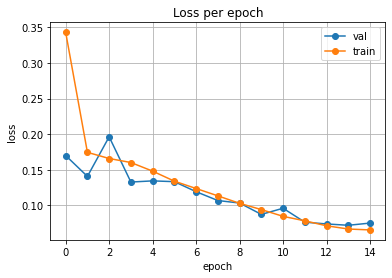

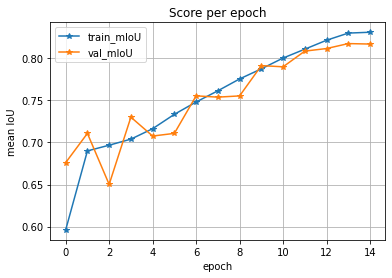

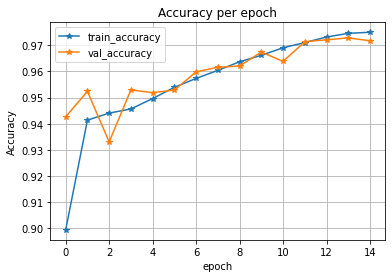

In [31]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [27]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [118]:
# resnext50_32x4d
model2 = smp.DeepLabV3Plus('efficientnet-b4', encoder_weights='imagenet', classes=4)

max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history2 = fit(epoch, model2, train_loader, val_loader, criterion, optimizer, sched)


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.089 
Epoch:1/15.. Train Loss: 0.218.. Val Loss: 0.089.. Train mIoU:0.677.. Val mIoU: 0.791.. Train Acc:0.933.. Val Acc:0.967.. Time: 48.92m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Epoch:2/15.. Train Loss: 0.099.. Val Loss: 0.124.. Train mIoU:0.782.. Val mIoU: 0.764.. Train Acc:0.964.. Val Acc:0.954.. Time: 42.37m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 0.099.. Val Loss: 0.090.. Train mIoU:0.786.. Val mIoU: 0.792.. Train Acc:0.964.. Val Acc:0.967.. Time: 41.06m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 0.094.. Val Loss: 0.092.. Train mIoU:0.790.. Val mIoU: 0.800.. Train Acc:0.966.. Val Acc:0.966.. Time: 41.12m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Loss Decreasing.. 0.089 >> 0.084 
Epoch:5/15.. Train Loss: 0.089.. Val Loss: 0.084.. Train mIoU:0.797.. Val mIoU: 0.796.. Train Acc:0.968.. Val Acc:0.969.. Time: 41.14m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Epoch:6/15.. Train Loss: 0.080.. Val Loss: 0.085.. Train mIoU:0.806.. Val mIoU: 0.801.. Train Acc:0.970.. Val Acc:0.968.. Time: 41.28m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Loss Decreasing.. 0.084 >> 0.078 
Epoch:7/15.. Train Loss: 0.074.. Val Loss: 0.078.. Train mIoU:0.819.. Val mIoU: 0.812.. Train Acc:0.972.. Val Acc:0.971.. Time: 41.20m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Loss Decreasing.. 0.078 >> 0.065 
Epoch:8/15.. Train Loss: 0.066.. Val Loss: 0.065.. Train mIoU:0.830.. Val mIoU: 0.835.. Train Acc:0.975.. Val Acc:0.976.. Time: 41.30m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Epoch:9/15.. Train Loss: 0.062.. Val Loss: 0.066.. Train mIoU:0.837.. Val mIoU: 0.836.. Train Acc:0.976.. Val Acc:0.975.. Time: 41.28m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Loss Decreasing.. 0.065 >> 0.060 
Epoch:10/15.. Train Loss: 0.055.. Val Loss: 0.060.. Train mIoU:0.847.. Val mIoU: 0.847.. Train Acc:0.978.. Val Acc:0.977.. Time: 41.21m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Loss Decreasing.. 0.060 >> 0.060 
Epoch:11/15.. Train Loss: 0.051.. Val Loss: 0.060.. Train mIoU:0.858.. Val mIoU: 0.855.. Train Acc:0.980.. Val Acc:0.978.. Time: 41.34m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Loss Decreasing.. 0.060 >> 0.056 
Epoch:12/15.. Train Loss: 0.047.. Val Loss: 0.056.. Train mIoU:0.866.. Val mIoU: 0.855.. Train Acc:0.981.. Val Acc:0.979.. Time: 41.28m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Loss Decreasing.. 0.056 >> 0.054 
Epoch:13/15.. Train Loss: 0.044.. Val Loss: 0.054.. Train mIoU:0.872.. Val mIoU: 0.865.. Train Acc:0.982.. Val Acc:0.980.. Time: 41.31m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Loss Decreasing.. 0.054 >> 0.054 
Epoch:14/15.. Train Loss: 0.041.. Val Loss: 0.054.. Train mIoU:0.878.. Val mIoU: 0.863.. Train Acc:0.983.. Val Acc:0.980.. Time: 41.32m


  0%|          | 0/3281 [00:00<?, ?it/s]

  0%|          | 0/821 [00:00<?, ?it/s]

Epoch:15/15.. Train Loss: 0.040.. Val Loss: 0.054.. Train mIoU:0.880.. Val mIoU: 0.863.. Train Acc:0.983.. Val Acc:0.980.. Time: 43.15m
Total time: 629.28 m


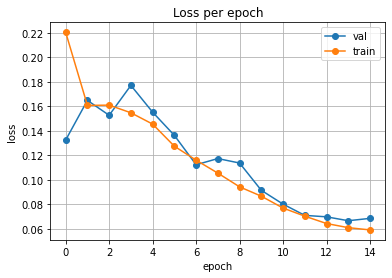

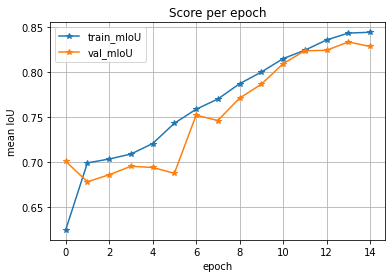

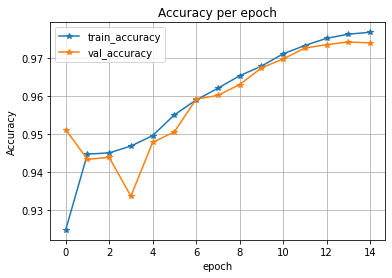

In [33]:
plot_loss(history2)
plot_score(history2)
plot_acc(history2)

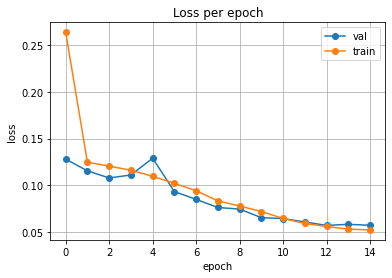

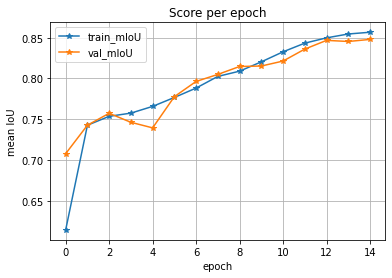

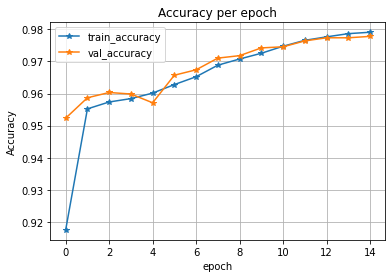

In [143]:
plot_loss(history2)
plot_score(history2)
plot_acc(history2)

In [144]:
torch.save(model2, 'effb4.pt')

In [16]:
def predict(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        
        output = model(image)
        #print(output)
        #return output
        #sigmoid?
        masked = torch.argmax(output, dim=1)
        
        masked = masked.cpu().squeeze(0)
    return masked

In [17]:
def predict_folds(models, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    results = []
    for model in models:
        model.eval()
        t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
        img = t(image)
        model.to(device); img=img.to(device)
        with torch.no_grad():
        
            img = img.unsqueeze(0)
        
            output = model(img)
            results.append(np.array(output.cpu()))
    
    results = np.mean(np.array(results), axis=0 )
    masked = torch.argmax(torch.from_numpy(results), dim=1)
    masked = masked.cpu().squeeze(0)
            
    return masked

In [18]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [19]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [20]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, X, transform=None):
        self.img_path = img_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X.loc[idx].id + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            aug = self.transform(image=img)
            img = Image.fromarray(aug['image'])
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        return img

In [107]:
MASK_PATH

'train/mask/'

In [16]:
import cv2

In [14]:
def create_testdf():
    name = []
    for dirname, _, filenames in os.walk('test/'):
        for filename in filenames:
            name.append(filename.split('.png')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_testdf()
print('Total Images: ', len(df))

Total Images:  1000


In [58]:
pred_mask

tensor([[[[ 12.7072,  13.7724,  14.8375,  ...,   8.2641,   7.5816,   6.8991],
          [ 13.5797,  14.6939,  15.8081,  ...,   8.8863,   8.1650,   7.4437],
          [ 14.4521,  15.6154,  16.7787,  ...,   9.5085,   8.7483,   7.9882],
          ...,
          [  7.0730,   7.4557,   7.8383,  ...,   6.2355,   5.8792,   5.5230],
          [  6.7982,   7.1611,   7.5239,  ...,   6.0055,   5.6641,   5.3227],
          [  6.5234,   6.8665,   7.2095,  ...,   5.7755,   5.4489,   5.1224]],

         [[ -2.3314,  -2.5105,  -2.6895,  ...,  -0.3957,  -0.4162,  -0.4368],
          [ -2.1963,  -2.3221,  -2.4478,  ...,  -0.3927,  -0.4225,  -0.4522],
          [ -2.0612,  -2.1337,  -2.2061,  ...,  -0.3898,  -0.4288,  -0.4677],
          ...,
          [ -2.8557,  -2.9151,  -2.9746,  ...,  -2.2441,  -2.2483,  -2.2526],
          [ -2.8337,  -2.9284,  -3.0230,  ...,  -2.2682,  -2.2430,  -2.2179],
          [ -2.8117,  -2.9416,  -3.0715,  ...,  -2.2922,  -2.2377,  -2.1832]],

         [[-26.3961, -29.1293,

In [ ]:
model1 = torch.load('model_mIoU-0.867_fold_0.pt')
model2 = torch.load('model_mIoU-0.867_fold_1.pt')
model3 = torch.load('model_mIoU-0.873_fold_2.pt')
model4 = torch.load('model_mIoU-0.870_fold_3.pt')
model5 = torch.load('model_mIoU-0.873_fold_4.pt')
model6 = torch.load('model_v2_mIoU-0.865.pt')

models = [model1, model2, model3, model4, model5, model6]

t_test = A.Resize(512, 1024, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset('test/', df, transform=t_test)

pred_mask = predict_folds(models, test_set[0])

In [95]:
np.unique(pred_mask, return_counts=True)

(array([0, 1, 2], dtype=int64), array([447865,  55309,  21114], dtype=int64))

In [93]:
np.unique(pred_mask, return_counts=True)

(array([0, 1, 2], dtype=int64), array([447319,  55766,  21203], dtype=int64))

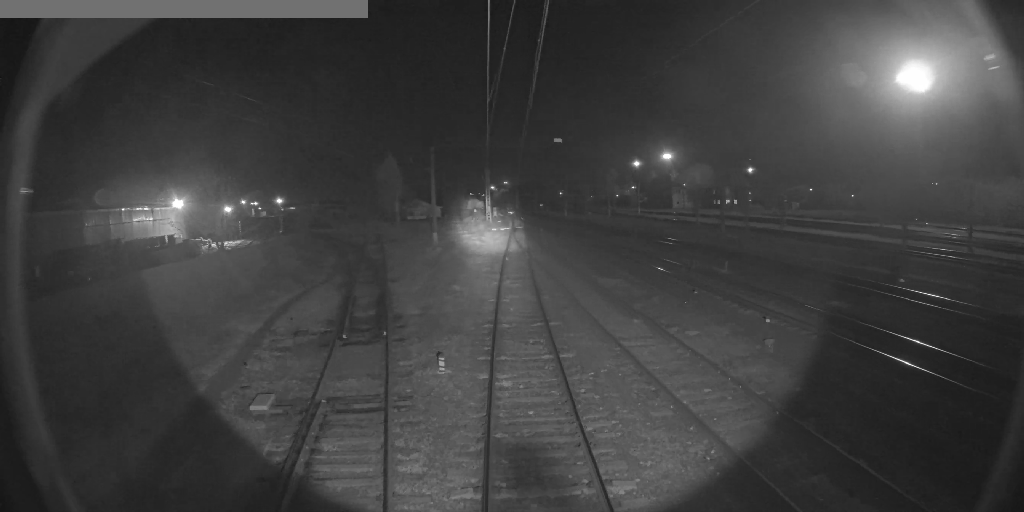

In [96]:
test_set[0]

Image Size (512, 1024, 3)
Mask Size (512, 1024)


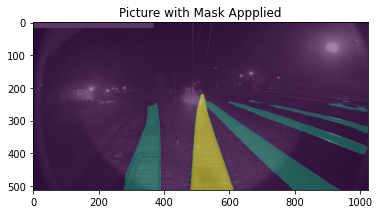

In [99]:
#img = Image.open(IMAGE_PATH + df['id'][100] + '.png')
#mask = cv2.imread(MASK_PATH + df['id'][100] + '.png', cv2.IMREAD_GRAYSCALE)
print('Image Size', np.asarray(test_set[0]).shape)
print('Mask Size', np.asarray(pred_mask).shape)

plt.imshow(test_set[0])
plt.imshow(pred_mask, alpha=0.5)
plt.title('Picture with Mask Appplied')
plt.show()

Image Size (512, 1024, 3)
Mask Size (512, 1024)


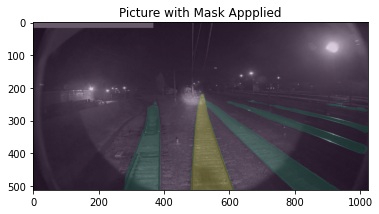

In [103]:
#img = Image.open(IMAGE_PATH + df['id'][100] + '.png')
#mask = cv2.imread(MASK_PATH + df['id'][100] + '.png', cv2.IMREAD_GRAYSCALE)
print('Image Size', np.asarray(test_set[0]).shape)
print('Mask Size', np.asarray(pred_mask).shape)

plt.imshow(test_set[0])
plt.imshow(pred_mask, alpha=0.2)
plt.title('Picture with Mask Appplied')
plt.show()

In [121]:
t_test = A.Resize(512, 1024, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset('test/', df, transform=t_test)

for i in range(len(df)):
    pred_mask = predict(model2, test_set[i])
    img_path = 'test/' + df.loc[i].id + '.png'
    im = np.array(Image.open(img_path))
    
    res = cv2.resize(np.array(pred_mask), dsize=(im.shape[1], im.shape[0]), interpolation=cv2.INTER_NEAREST)
    res[res == 1] = 6
    res[res == 2] = 7
    res[res == 3] = 10
    resized_mask = np.repeat(res[:, :, None], 3, axis=2)
    
    im = Image.fromarray(resized_mask.astype(np.uint8))
    im = im.convert('L')
    im.save('submit/' + df.loc[i].id + '.png')

In [21]:
model1 = torch.load('model_mIoU-0.866_fold_0.pt')
model2 = torch.load('model_mIoU-0.872_fold_1.pt')
model3 = torch.load('model_mIoU-0.870_fold_2.pt')
model4 = torch.load('model_mIoU-0.875_fold_3.pt')
model5 = torch.load('model_mIoU-0.872_fold_4.pt')
#model6 = torch.load('model_v2_mIoU-0.865.pt')

models = [model1, model2, model3, model4, model5]

t_test = A.Resize(512, 1024, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset('test/', df, transform=t_test)



for i in range(len(df)):
    pred_mask = predict_folds(models, test_set[i])
    img_path = 'test/' + df.loc[i].id + '.png'
    im = np.array(Image.open(img_path))
    
    res = cv2.resize(np.array(pred_mask), dsize=(im.shape[1], im.shape[0]), interpolation=cv2.INTER_NEAREST)
    res[res == 1] = 6
    res[res == 2] = 7
    res[res == 3] = 10
    resized_mask = np.repeat(res[:, :, None], 3, axis=2)
    
    im = Image.fromarray(resized_mask.astype(np.uint8))
    im = im.convert('L')
    im.save('submit/' + df.loc[i].id + '.png')

In [60]:
torch.argmax(pred_mask, dim=1)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')

In [63]:
pred_mask[0].shape

torch.Size([4, 512, 1024])

In [49]:
torch.argmax(pred_mask, dim=1).shape

torch.Size([1, 512, 1024])

In [ ]:
        #masked = torch.argmax(output, dim=1)
        
        #masked = masked.cpu().squeeze(0)

In [100]:
resized_mask.shape

(1512, 2688, 3)

In [64]:
image, mask = test_set[3]
image = np.array(image)
t_test = A.Resize(image.shape[0], image.shape[1], interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)
pred_mask, score = predict_image_mask_miou(model2, image, mask)

In [72]:
np.array(test_set[0][0]).shape

(768, 1152, 3)

In [65]:
np.unique(pred_mask)

array([0, 1, 2], dtype=int64)

In [68]:
pred_mask.shape

torch.Size([768, 1152])

In [44]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [45]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/821 [00:00<?, ?it/s]

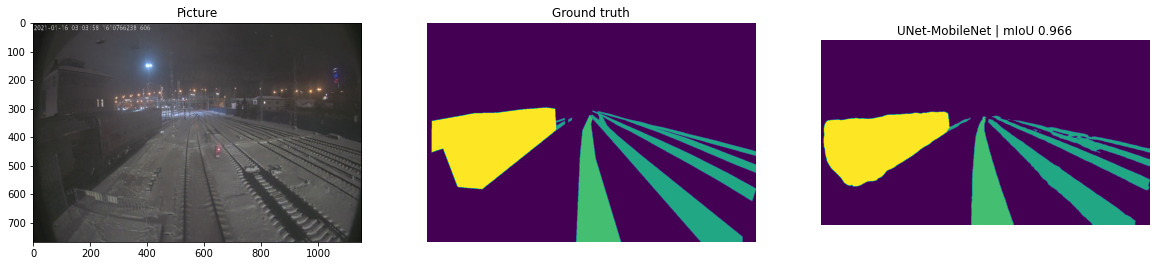

In [101]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(res)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()